In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import odeint
from math import pi, log
from numpy import linspace
from random import random
import tensorflow as tf


In [2]:
def van_der_pol_oscillator_deriv(x, t): #dydt for vdp
    nx0 = x[1]
    nx1 = -mu * (x[0] ** 2.0 - 1.0) * x[1] - x[0]
    res = np.array([nx0, nx1])
    return res

def window_transform(array, window_length, stride):
    # convert flat timeseries into windowed chonkasaurus of shape of (num_chunk, window_size)
    array = array.flatten()
    length = array.shape[0]
    indexer = np.arange(window_length).reshape(1, -1) + stride * np.arange(int(round((length - window_length)/stride))).reshape(-1, 1)
    return array[indexer]

In [3]:
for i in range(50):

    mu = 0.1*i + 0.1 #mu for dataset ranges from 0.1 to 5  

    if (mu < 2): #compute approximate time period of vdp oscillator
        T_p = 2*pi*(1 + (mu**2)/16.0)
    else:
        T_p = (3.0 - log(2.0))*mu + 2*pi*mu**(-1/3.0)
    
    ts = linspace(0.0, 15*T_p, np.round(1500*T_p)) #run simulator for 15 time periods, step 0.01

    xs = odeint(van_der_pol_oscillator_deriv, [-0.5, -0.5], ts)
    start_index = int(round(1390*T_p))
    stop_index = int(round(1500*T_p)) #use data from last period, assuming it has converged to the limit cycle
    data_windowed_x = window_transform(xs[:,0], 50, 20)
    data_windowed_y = window_transform(xs[:,1], 50, 20)
    data_mui = np.hstack([data_windowed_x, data_windowed_y])
    train_test = np.zeros((data_mui.shape[0],1))
    train_test.fill((random() > 0.8)) #20% chance of being in testset
    output = np.ones((data_mui.shape[0],1)) * mu
    if (i == 0):
        X = data_mui
        Y = output
        T = train_test
    else:
        X = np.vstack([X, data_mui])
        Y = np.vstack([Y, output])
        T = np.vstack([T, train_test])

X_train = X[(T[:,0] < 0.5), :]
X_test = X[(T[:,0] > 0.5), :]
y_train = Y[(T[:,0] < 0.5), :]
y_test = Y[(T[:,0] > 0.5), :]

In [11]:
# NN class
class NN():
  def __init__(self, x_dim, y_dim, hidden_size, init_stddev_1_w, init_stddev_1_b, init_stddev_2_w, init_stddev_2_b, init_stddev_3_w, learning_rate):
    # setting up as for a usual NN
    self.x_dim = x_dim
    self.y_dim = y_dim
    self.hidden_size = hidden_size
    self.learning_rate = learning_rate
    
    # set up NN
    self.inputs = tf.placeholder(tf.float32, [None, x_dim], name='inputs')
    self.y_target = tf.placeholder(tf.float32, [None, y_dim], name='target')
    
    self.layer_1_w = tf.layers.Dense(hidden_size, activation=tf.nn.relu, # try using tf.nn.relu, tf.erf, tf.nn.tanh etc.
                                     kernel_initializer=tf.random_normal_initializer(mean=0.,stddev=init_stddev_1_w),
                                     bias_initializer=tf.random_normal_initializer(mean=0.,stddev=init_stddev_1_b))
    self.layer_1 = self.layer_1_w.apply(self.inputs)
    self.layer_2_w = tf.layers.Dense(hidden_size, activation=tf.nn.relu, # try using tf.nn.relu, tf.erf, tf.nn.tanh etc.
                                     kernel_initializer=tf.random_normal_initializer(mean=0.,stddev=init_stddev_2_w),
                                     bias_initializer=tf.random_normal_initializer(mean=0.,stddev=init_stddev_2_b))
    self.layer_2 = self.layer_2_w.apply(self.layer_1)
    self.output_w = tf.layers.Dense(y_dim, activation=None, use_bias=False,
                                    kernel_initializer=tf.random_normal_initializer(mean=0.,stddev=init_stddev_3_w))
    self.output = self.output_w.apply(self.layer_2)
    
    # set up loss and optimiser - we'll modify this later with anchoring regularisation
    self.opt_method = tf.train.AdamOptimizer(self.learning_rate)
    num_data_inv = tf.cast(tf.divide(1, tf.shape(self.inputs)[0]), dtype=tf.float32)
    self.mse_ = num_data_inv * tf.reduce_sum(tf.square(self.y_target - self.output))
    self.loss_ = num_data_inv * tf.reduce_sum(tf.square(self.y_target - self.output))
    self.optimizer = self.opt_method.minimize(self.loss_)
    return
    
    
  def get_weights(self, sess):
    '''method to return current params'''
    ops = [self.layer_1_w.kernel, self.layer_1_w.bias, self.layer_2_w.kernel, self.layer_2_w.bias, self.output_w.kernel]
    w1, b1, w2, b2, w3 = sess.run(ops)
    return w1, b1, w2, b2, w3
    
  def anchor(self, sess, lambda_anchor):
    '''regularise around initialised parameters'''
    w1, b1, w2, b2, w3 = self.get_weights(sess)
    
    # get initial params
    self.w1_init, self.b1_init, self.w2_init, self.b2_init, self.w3_init = w1, b1, w2, b2, w3
    loss_anchor = lambda_anchor[0]*tf.reduce_sum(tf.square(self.w1_init - self.layer_1_w.kernel))
    loss_anchor += lambda_anchor[1]*tf.reduce_sum(tf.square(self.b1_init - self.layer_1_w.bias))
    loss_anchor += lambda_anchor[2]*tf.reduce_sum(tf.square(self.w2_init - self.layer_2_w.bias))
    loss_anchor += lambda_anchor[3]*tf.reduce_sum(tf.square(self.b2_init - self.layer_2_w.bias))
    loss_anchor += lambda_anchor[4]*tf.reduce_sum(tf.square(self.w3_init - self.output_w.kernel))
    
    # combine with original loss
    self.loss_ = self.loss_ + tf.cast(1/tf.shape(self.inputs)[0], dtype=tf.float32) * loss_anchor
    self.optimizer = self.opt_method.minimize(self.loss_)
    return
    
  def predict(self, x, sess):
    '''predict method'''
    feed = {self.inputs: x}
    y_pred = sess.run(self.output, feed_dict=feed)
    return y_pred

In [12]:
#Do minmax scaling
min_x = X_train.min(0)
max_x = X_train.max(0)
X_train = 2*(X_train - min_x)/(max_x - min_x) - 1
X_test = 2*(X_test - min_x)/(max_x - min_x) - 1
#Do minmax scaling
min_y = y_train.min(0)
max_y = y_train.max(0)
y_train = 2*(y_train - min_y)/(max_y - min_y) - 1
y_test = 2*(y_test - min_y)/(max_y - min_y) - 1
#columns of x and y are [-1,1] now

In [13]:
# hyperparameters
n = X_train.shape[0]
print(n)
x_dim = X_train.shape[1]
print(x_dim)
y_dim = y_train.shape[1]
print(y_dim)

data_noise = 0.000625 #noise variance
n_ensembles = 25
hidden_size = 30
init_stddev_1_w =  np.sqrt(1.0/x_dim) #tune 1.0
init_stddev_1_b = init_stddev_1_w # set these equal
init_stddev_2_w =  1.0/np.sqrt(hidden_size) #tune 1.0
init_stddev_2_b = init_stddev_2_w # set these equal
init_stddev_3_w = 1.0/np.sqrt(hidden_size) #tune 1.0
lambda_anchor = data_noise/(np.array([init_stddev_1_w,init_stddev_1_b,init_stddev_2_w,init_stddev_2_b,init_stddev_3_w])**2)

n_epochs = 512
batch_size = 32
learning_rate = 0.00001

29093
100
1


In [14]:
NNs=[]
y_prior=[]
tf.reset_default_graph()
sess = tf.Session()

# loop to initialise all ensemble members, get priors
for ens in range(0,n_ensembles):
    NNs.append(NN(x_dim, y_dim, hidden_size, init_stddev_1_w, init_stddev_1_b, init_stddev_2_w, init_stddev_2_b, init_stddev_3_w,
                  learning_rate))
    
    # initialise only uninitialized variables - stops overwriting ensembles already created
    global_vars = tf.global_variables()
    is_not_initialized   = sess.run([tf.is_variable_initialized(var) for var in global_vars])
    not_initialized_vars = [v for (v, f) in zip(global_vars, is_not_initialized) if not f]
    if len(not_initialized_vars):
        sess.run(tf.variables_initializer(not_initialized_vars))
    
    # do regularisation now that we've created initialisations
    NNs[ens].anchor(sess, lambda_anchor)

In [15]:
def fn_predict_ensemble(NNs,X_train):
  y_pred=[]
  for ens in range(0,n_ensembles):
    y_pred.append(NNs[ens].predict(X_train, sess))
  y_preds_train = np.array(y_pred)
  y_preds_mu_train = np.mean(y_preds_train,axis=0)
  y_preds_std_train_epi = np.std(y_preds_train,axis=0)
  y_preds_std_train = np.sqrt(np.square(y_preds_std_train_epi) + np.square(data_noise)) #add measurement noise
  return y_preds_train, y_preds_mu_train, y_preds_std_train_epi, y_preds_std_train

In [16]:
y_preds_train, y_preds_mu_train, __, y_preds_std_train = fn_predict_ensemble(NNs,X_train)
y_preds_test, y_preds_mu_test, __, y_preds_std_test = fn_predict_ensemble(NNs,X_test)

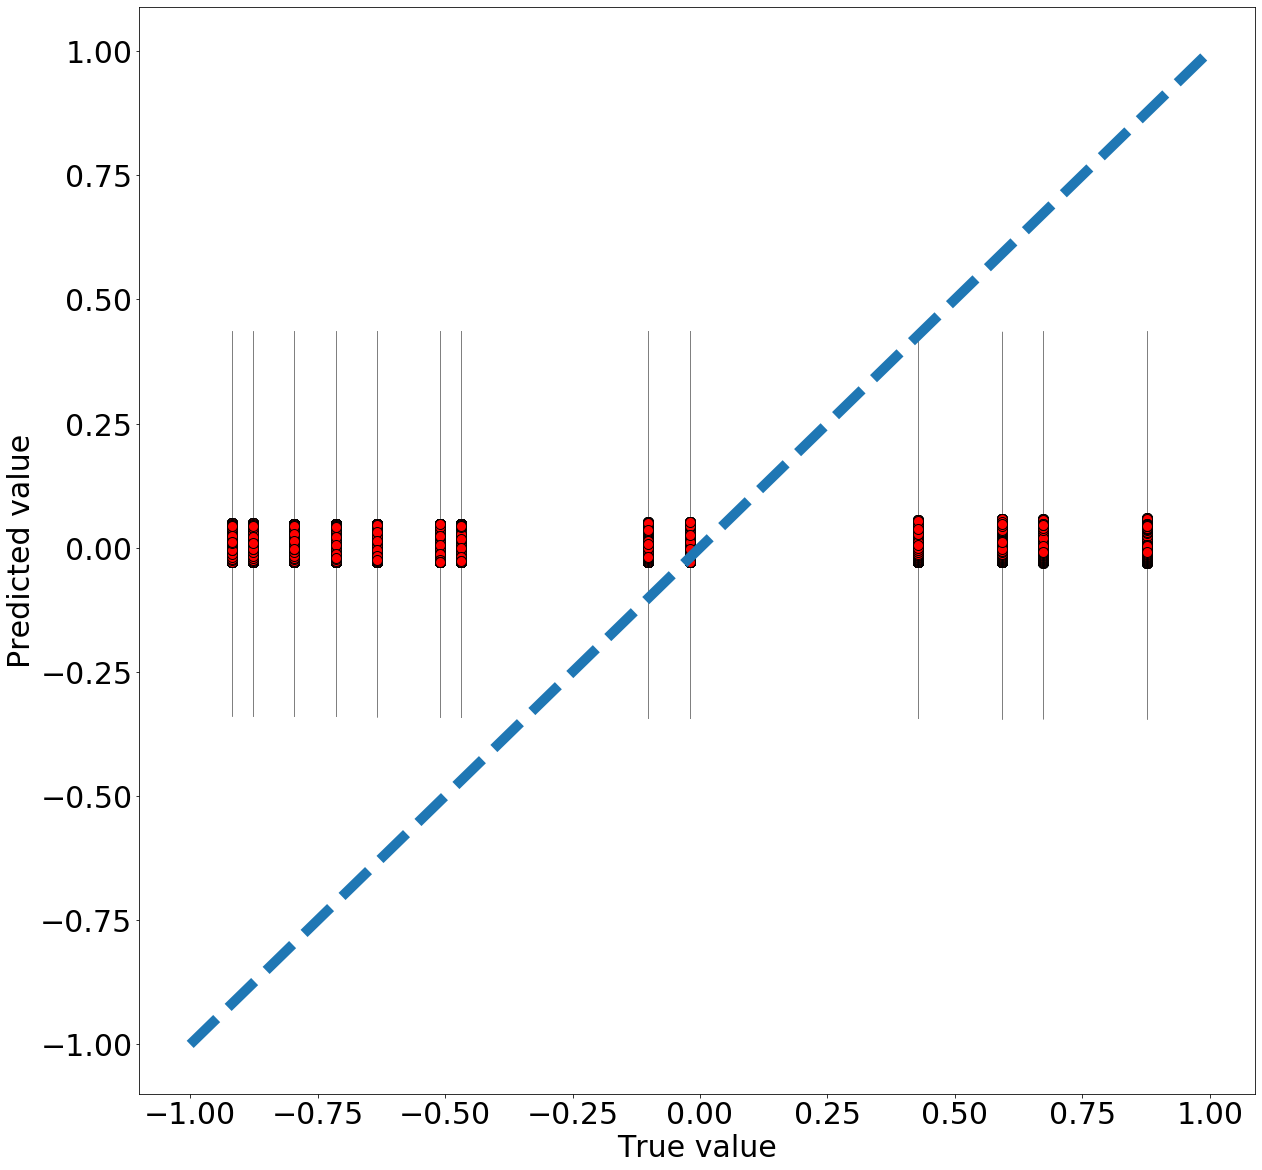

In [17]:
# plot prior predictive distribution
plt.rcParams.update({'font.size': 30})
plt.figure(figsize=(20,20))
plt.errorbar(y_test[:,0], y_preds_mu_test[:,0], yerr=(y_preds_std_test[:,0]*1),linewidth = 0.5, color = 'gray', ms=10,mfc='red',mec='black', fmt='o')
plt.plot(np.arange(np.min(y_train[:,0]), np.max(y_train[:,0]), 0.01), np.arange(np.min(y_train[:,0]), np.max(y_train[:,0]), 0.01), linewidth = 10, linestyle = 'dashed',zorder = 100)
plt.xlabel('True value')
plt.ylabel('Predicted value')
plt.show()